In [1]:
import rioxarray as rxr
import xarray as xr
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


In [2]:

img_path = Path('/projects/my-private-bucket/HLS-1DCNN-AGB/data/tif/HLS_composites/yearly/br_af_grid90km_evi2_p95/tile_089/HLS_89_01-01_12-30_2022_2022_percentile95.0evi2.tif')

# --- Open lazily with raterio open - good for large rasters - dask-backed array
# Masked masks no data values 
# Chunks
# da = rxr.open_rasterio(img_path, masked=True, chunks={"x": 2048, "y": 2048})

da = rxr.open_rasterio(img_path, masked=True, chunks={"x": 1024, "y": 1024})
da


<xarray.DataArray (band: 23, y: 3000, x: 3000)> Size: 2GB
dask.array<open_rasterio-ace4ca88e2d537a822ac0c2a2f856199<this-array>, shape=(23, 3000, 3000), dtype=float64, chunksize=(23, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 184B 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23
  * x            (x) float64 24kB 5.469e+06 5.469e+06 ... 5.559e+06 5.559e+06
  * y            (y) float64 24kB 7.314e+06 7.314e+06 ... 7.224e+06 7.224e+06
    spatial_ref  int64 8B 0
Attributes:
    OVR_RESAMPLING_ALG:  NEAREST
    AREA_OR_POINT:       Area
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           ('Blue', 'Green', 'Red', 'NIR', 'SWIR', 'SWIR2', 'ND...

In [19]:
# print("Bands:", da.sizes.get("band", 1))
# print("CRS:", da.rio.crs)
# print("Transform:", da.rio.transform())
# print("Resolution:", da.rio.resolution())
# print("Nodata:", da.rio.nodata)
# print("Bounds:", da.rio.bounds())


In [17]:
# import fiona
# gpkg_fn = '/projects/my-private-bucket/HLS-1DCNN-AGB/data/shp/atlantic_forest/tiles/br_af_grid90km_prj.gpkg'
# with fiona.open(gpkg_fn) as src:
#     print(src.crs)

In [21]:
# with rasterio.open(img_path) as src:
#     print("Driver:", src.driver)
#     print("Width x Height:", src.width, "x", src.height)
#     print("CRS:", src.crs)
#     print("Count (bands):", src.count)
#     print("DType:", src.dtypes)
#     print("Tags:", src.tags())         # global tags
#     # Per-band tags (if any)
#     for b in range(1, src.count+1):
#         if src.tags(b):
#             print(f"Band {b} tags:", src.tags(b))


In [23]:
# If single-band, this still works (band=1)
# b1 = da.sel(band=1)
# b1


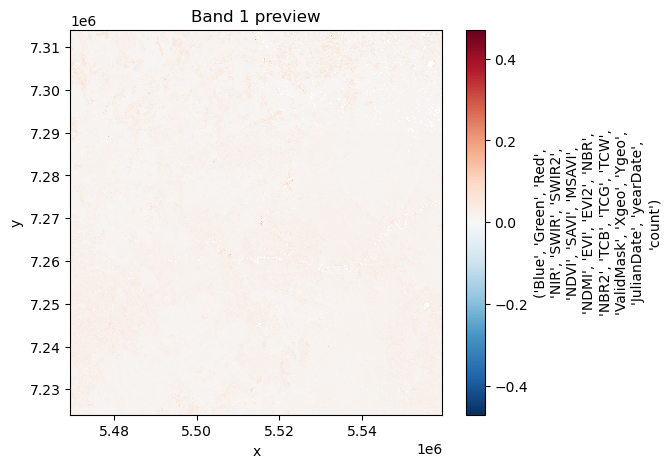

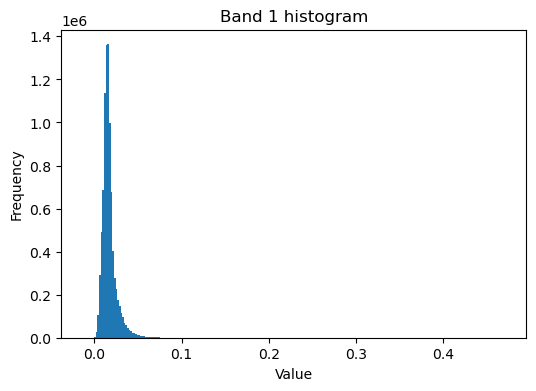

In [24]:
# Quicklook (downsampled automatically if large)
plt.figure(figsize=(6,5))
b1.plot.imshow(add_colorbar=True)   # do not set colors unless you want to
plt.title("Band 1 preview")
plt.show()

# Histogram (masked NaNs are ignored)
arr = b1.values
arr = arr[np.isfinite(arr)]
plt.figure(figsize=(6,4))
plt.hist(arr.ravel(), bins=256)
plt.title("Band 1 histogram")
plt.xlabel("Value"); plt.ylabel("Frequency")
plt.show()


In [26]:
# Lazy-friendly quantiles; compute() triggers dask execution
b1q = b1.chunk({"y": -1, "x": -1})   # one chunk along each reduced dim
q = b1q.quantile([0.0, 0.05, 0.25, 0.5, 0.75, 0.95, 1.0], dim=("y", "x")).compute()

mean = float(b1.mean().compute())
std  = float(b1.std().compute())
print("Mean:", mean, "Std:", std)

# Robust min/max ignoring nodata
vmin = float(b1.where(np.isfinite(b1)).min().compute())
vmax = float(b1.where(np.isfinite(b1)).max().compute())
print("Min:", vmin, "Max:", vmax)


Mean: 0.017028587985996668 Std: 0.008280985506482937
Min: -0.0134 Max: 0.47100000000000003


In [ ]:
# Example bbox (minx, miny, maxx, maxy) in the raster CRS
bbox = (-50.0, -25.0, -49.0, -24.0)  # replace with your area
subset = b1.rio.clip_box(*bbox)
subset


In [ ]:
# Window around a given (row, col) center
row, col = int(b1.sizes["y"]//2), int(b1.sizes["x"]//2)
window_size = 512
r0, r1 = max(0, row-window_size//2), min(row+window_size//2, b1.sizes["y"])
c0, c1 = max(0, col-window_size//2), min(col+window_size//2, b1.sizes["x"])
chip = b1.isel(y=slice(r0, r1), x=slice(c0, c1)).compute()

plt.figure(figsize=(5,5))
chip.plot.imshow(add_colorbar=True)
plt.title("Central 512×512 chip")
plt.show()


In [ ]:
# Export
# out_tif = img_path.with_name(img_path.stem + "_band1_subset.tif")
subset.rio.to_raster(out_tif, compress="deflate", predictor=2)
out_tif
